In [14]:
import sys
sys.path.append("../Pupillengröße/Skripte/")

import os
import numpy as np
from pyplr import utils
import pandas as pd
from classPLRfromGitHub import PLR
from pyplr import graphing
from pyplr import preproc
import matplotlib.pyplot as plt
#import tkinter as tk
#from tkinter import simpledialog
import sys
import importlib
import checkdataPLR
import pup_config
import importlib
importlib.reload(pup_config)
#from preprocessing import ProcessConfig

<module 'pup_config' from '/home/marco/Projects/KatharinaMeier/Pupille/Lichtreflex/../Pupillengröße/Skripte/pup_config.py'>

In [15]:
# Define the subject_id
subject_id = 'PJ25_1_PLR3'

rec_dir=f"{pup_config.obj_dir}/Testi"
utils.print_file_structure(rec_dir)

Testi/
    annotation_timestamps.npy
    exports/
        000/
            annotations.csv
            pupil_positions.csv
    pyplr_analysis/


In [16]:
# define the patient ID for the dataframe and assign the 4 light strenghts
Light_strenght_1 = 1
Light_strenght_2 = 2
Light_strenght_3 = 3
Light_strenght_4 = 4



# Sampling frequency
SAMPLE_RATE = 120

# Columns to load
use_cols = ['confidence',
           'method',
            'pupil_timestamp',
            'eye_id',
            'diameter']

pupil_cols = ['diameter']

# Check if the pyplr_analysis directory exists
if not os.path.exists(os.path.join(rec_dir, 'pyplr_analysis')):
    # Create the directory if it doesn't exist
    os.makedirs(os.path.join(rec_dir, 'pyplr_analysis'))

# Get a handle on a subject
s = utils.new_subject(
    rec_dir, export='000', out_dir_nm='pyplr_analysis')

************************************************************
************************** Testi ***************************
************************************************************


In [17]:
# Load pupil data, method has to be changed to '3d' otherwise multiple repeat error
#eye_id=best takes the eye with the best confidence, eye_id=0 takes right, 1 takes left
#samples = utils.load_pupil(
#    s['data_dir'], eye_id='left', method='2d', cols=use_cols)
#samples

# load the pupil data for the current combination of eye_id and method
samples = utils.load_pupil(s['data_dir'], eye_id='right', method='2d', cols=use_cols)
print(samples)

Loaded 19202 samples
                 eye_id  confidence   diameter method
pupil_timestamp                                      
11084.694856          0    0.755467  88.009705     2d
11084.694856          0    0.755467  88.056568     2d
11084.702805          0    0.550408  88.793083     2d
11084.702805          0    0.086143  82.055675     2d
11084.710838          0    0.652256  89.174370     2d
...                 ...         ...        ...    ...
11164.675105          0    0.827152  44.349202     2d
11164.682846          0    0.980418  44.726498     2d
11164.682846          0    0.980418  44.724381     2d
11164.691170          0    0.896972  44.680588     2d
11164.691170          0    0.896972  44.684834     2d

[19202 rows x 4 columns]


Loaded 4 events


,index,label,duration
timestamp,,,
11085.691661,784,LIGHT_ON,NaN
11100.907497,1238,LIGHT_ON,NaN
11116.087441,1691,LIGHT_ON,NaN
11131.267511,2144,LIGHT_ON,NaN


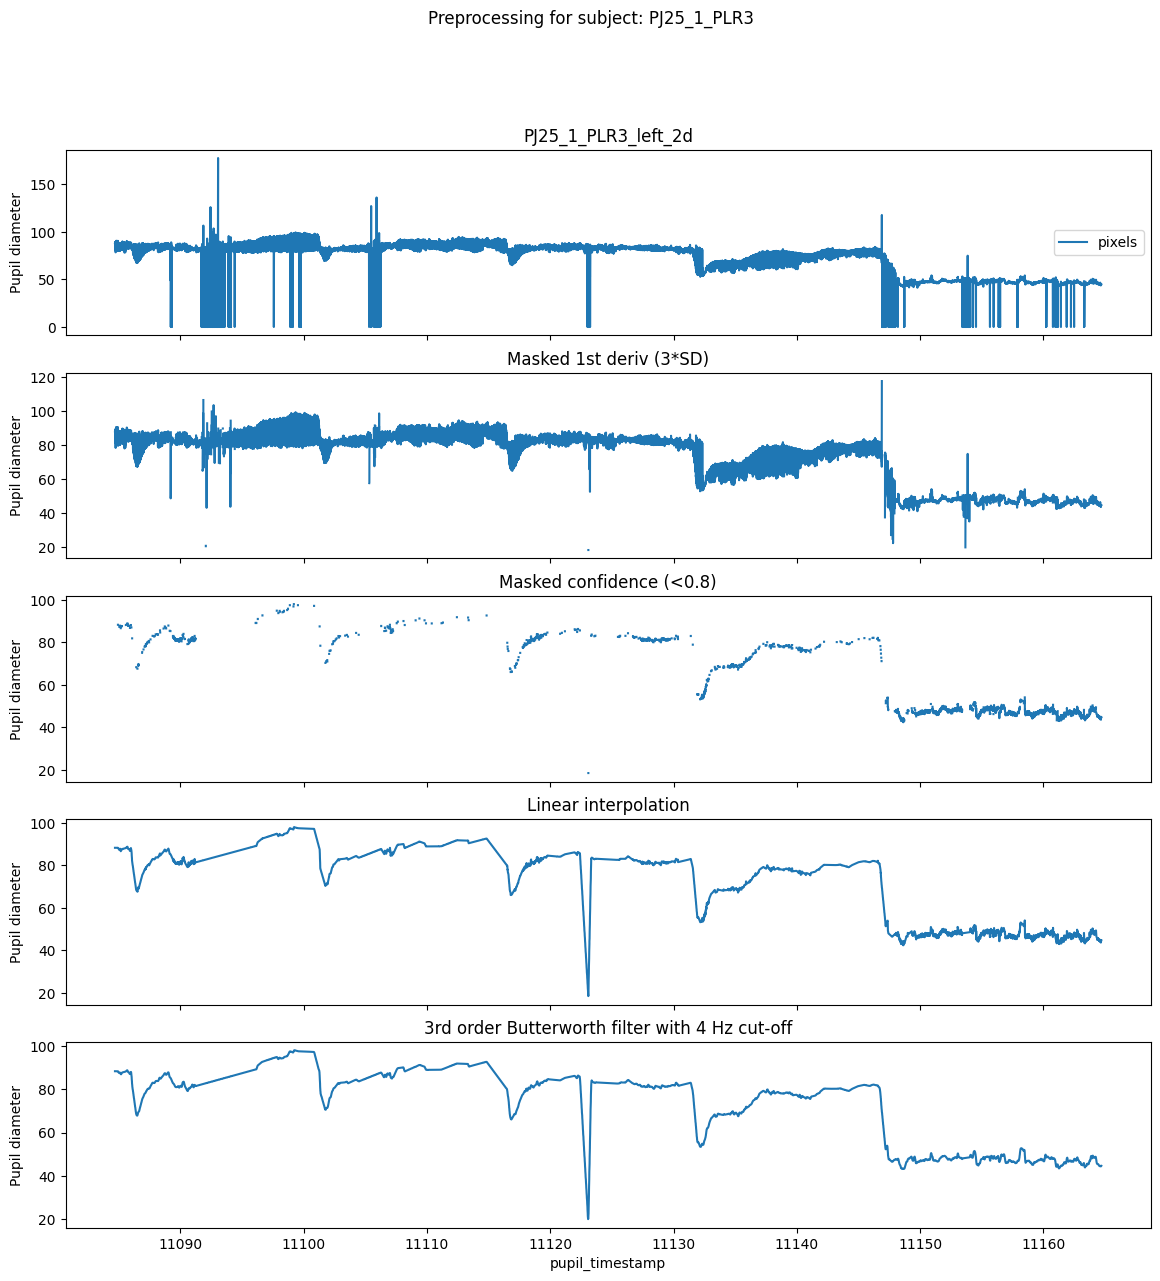

In [18]:
# Make figure for processing, append figure to pupil_preprocessing
f, axs = graphing.pupil_preprocessing_figure(nrows=5, subject=f"{subject_id}" )
# Plot the raw data
# Plot the raw data
samples[pupil_cols].plot(title=f"{subject_id}_left_2d", ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['pixels'])
# Mask first derivative
#Default is a threshold of 3 SD from the mean first derivate
# If there are a lot of blinks the mean first derivate is higher
# Therefore set the threshold lower 
samples = preproc.mask_pupil_first_derivative(
    samples, threshold=3.0, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples = preproc.mask_pupil_confidence(
    samples, threshold=0.8, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)
 

# Interpolate
samples = preproc.interpolate_pupil(
    samples, interp_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples = preproc.butterworth_series(
    samples, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

events = utils.load_annotations(s['data_dir'])
events


In [19]:
# Number of samples to extract and which sample
# should mark the onset of the event
# 120 data points equal one second with a sample rate of 120 
# Real duration is Duration-ONSET_IDX, example 240 equals 1 second
#ONSET_IDX is the time before light stimulus that gets sampled 
DURATION = 1200
ONSET_IDX = 120

# Extract the event ranges, gets range of total duration (720) and shifts the onset_idx to the left in time, therefore 120 is the 0 point
ranges = utils.extract(
    samples,
    events,
    offset=-ONSET_IDX,
    duration=DURATION,
    borrow_attributes=['color'])

# Convert data to numeric format
ranges = ranges.apply(pd.to_numeric, errors='coerce')

# Calculate baselines, the time before the onset is 0 to 120
baselines = ranges.loc[:, range(0, ONSET_IDX), :].groupby(level=0, axis=1).mean()

# New columns for percent signal change, simply adds 2 new columns with percent change
ranges = preproc.percent_signal_change(
    ranges, baselines, pupil_cols)
ranges

print(ranges.loc[0:3])

ranges1 = ranges.loc[0]
ranges2 = ranges.loc[1]
ranges3 = ranges.loc[2]
ranges4 = ranges.loc[3]

print(ranges4)


Extracted ranges for 4 events
             eye_id  confidence   diameter  method  interpolated   
event onset                                                        
0     0           0    0.700532  86.932350     NaN             1  \
      1           0    0.700532  86.961742     NaN             1   
      2           0    0.573115  86.996825     NaN             1   
      3           0    0.091742  87.036646     NaN             1   
      4           0    0.475018  87.080243     NaN             1   
...             ...         ...        ...     ...           ...   
3     1195        0    0.742568  70.731303     NaN             1   
      1196        0    0.118938  70.740879     NaN             1   
      1197        0    0.697560  70.745808     NaN             1   
      1198        0    0.894398  70.746868     NaN             0   
      1199        0    0.894398  70.744987     NaN             0   

                 orig_idx  color  diameter_pc  
event onset                          

,value
Baseline,82.478487
Latency_a,0.333333
Latency_b,0.583333
T2MaxVel,1.183333
T2MaxCon,1.816667
T2Rec75pc,0.000000
PeakCon,53.361929
ConAmplitude,29.116558
VelConMax,34.030077
VelConAve,19.409824


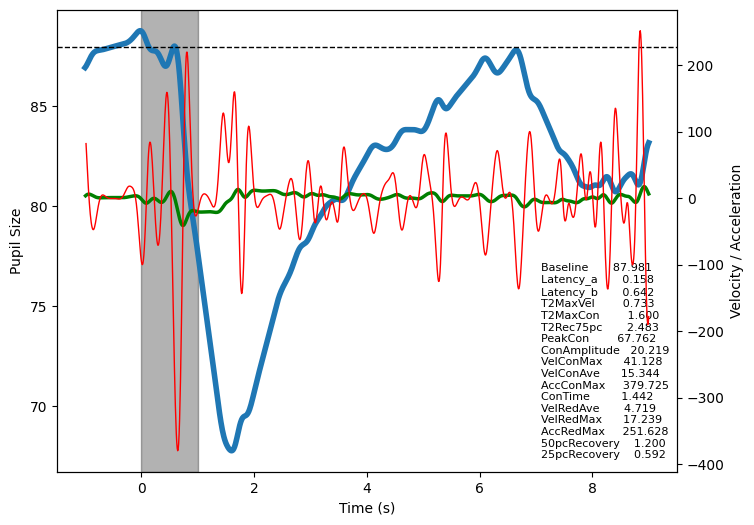

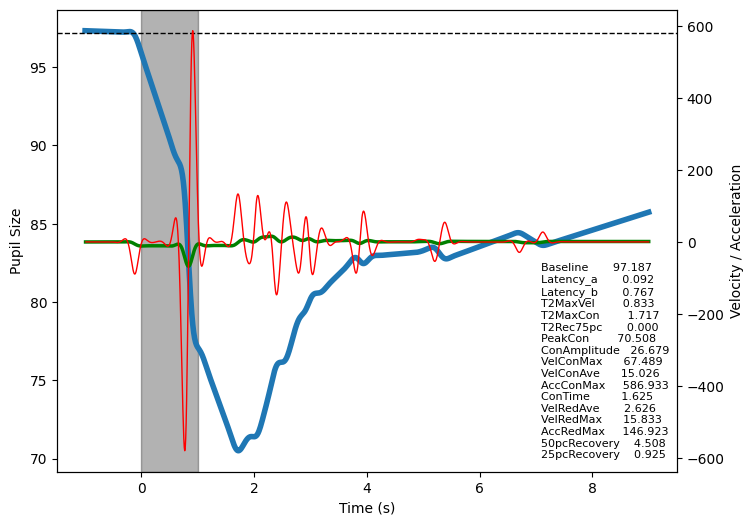

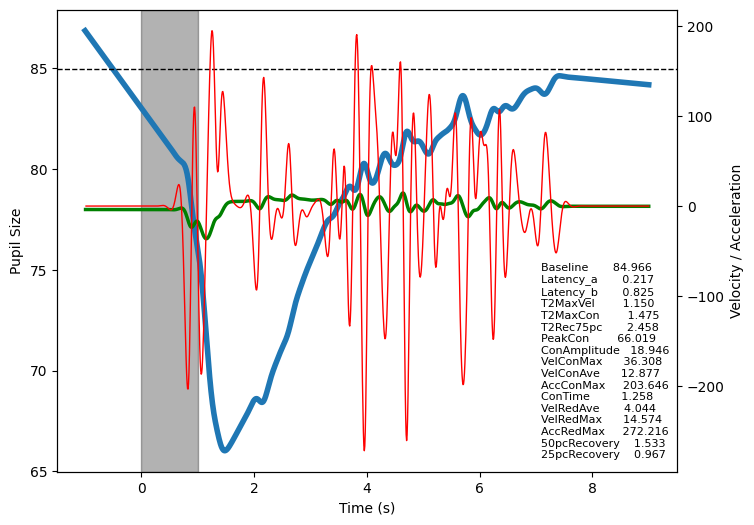

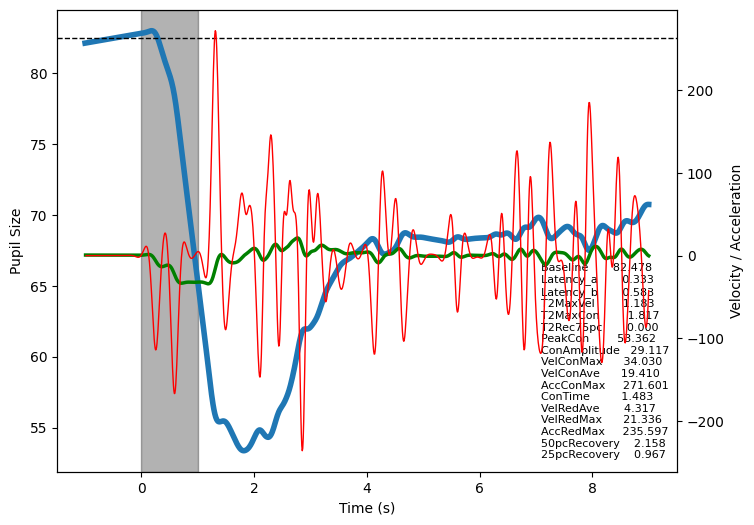

In [20]:
def get_average_plr(input_range):
    average_plr = input_range.groupby(level=0)['diameter'].mean().to_numpy()
    return PLR(average_plr,
              sample_rate=SAMPLE_RATE,
              onset_idx=ONSET_IDX,
              stim_duration=1)

plr1 = get_average_plr(ranges1)
plr2 = get_average_plr(ranges2)
plr3 = get_average_plr(ranges3)
plr4 = get_average_plr(ranges4)

plr_all = [plr1, plr2, plr3, plr4]


#plot graphs for vel = velocity in green, acc = acceleration in red and parameters
fig1 = plr1.plot(vel=True, acc=True, print_params=True)
fig2 = plr2.plot(vel=True, acc=True, print_params=True)
fig3 = plr3.plot(vel=True, acc=True, print_params=True)
fig4 = plr4.plot(vel=True, acc=True, print_params=True)

params1 = plr1.parameters()
params1

params2 = plr2.parameters()
params2

params3 = plr3.parameters()
params3

params4 = plr4.parameters()
params4



In [21]:
def get_pyplr_results(plr):
#D1 = baseline pupilsize, in mm
    D1 = plr.baseline()
    print("D1: ",D1)
    
    #D2 = minimum pupilsize, in mm 
    D2 = plr.peak_constriction()
    print("D2: ",D2)
    
    #AMP = constriction amplitude, in mm
    AMP = D1-D2
    print("AMP: ",AMP)
    
    #VCmax = maximum velocity of constriction, in mm/s
    VCmax = plr.max_constriction_velocity()
    print("VCmax: ",VCmax)
    
    #ACmax = maximum acceleration, in mm/s ?
    ACmax = plr.max_constriction_acceleration()
    print("ACmax: ",ACmax)
    
    #T1 = latency from the onset of the light stimulus to the maximum acceleration
    # in milliseconds - looks like in seconds on the graph  
    T1 = plr.latency_to_constriction_b()
    print("T1: ",T1)
    
    #T2 = time to maximum velocity, looks like in seconds on the graph 
    T2 = plr.time_to_max_velocity()
    print("T2: ",T2)
    
    #T3 = time to maximum constriction, in milliseconds - looks like in seconds on graph 
    T3 = plr.time_to_max_constriction()
    print("T3: ",T3)
    
    #relative constriction amplitude: AMP/D1
    rel_AMP = AMP/D1
    print("rel_AMP: ", rel_AMP)
    
    #time to 75% redilation 
    redil_75 = plr.time_to_75pc_recovery()
    print("redil_75", redil_75)
    
    #time to 50% redilation
    redil_50 = plr.time_to_50pc_recovery()
    print('redil_50', redil_50)
    
    redil_25 = plr.time_to_25pc_recovery()
    print('redil_25', redil_25)
    
    # create a CSV file
    return {
            'D1':D1,
            'D2': D2,
            'AMP': AMP,
            'VCmax':VCmax,
            'ACmax': ACmax,
            'T1': T1,
            'T2':T2,
            'T3':T3,
            "rel_AMP": rel_AMP,
            "redil_75": redil_75,
            'redil_50': redil_50,
            'redil_25': redil_25
            }

pyplr_results = {'Subject ID': [subject_id, subject_id, subject_id, subject_id],
                 'D1':[],
                 'D2':[],
                 'AMP': [],
                 'VCmax':[],
                 'ACmax': [],
                 'T1': [],
                 'T2':[],
                 'T3':[],
                 "rel_AMP": [],
                 "redil_75": [],
                 'redil_50': [],
                 'redil_25': [],
                 'Light_strenght': [Light_strenght_1, Light_strenght_2, Light_strenght_3, Light_strenght_4]}


In [22]:
plr_all = [plr1, plr2, plr3, plr4]

for plr in plr_all:
    pyplr_result = get_pyplr_results(plr)
    pyplr_results["D1"].append(pyplr_result["D1"])
    pyplr_results["D2"].append(pyplr_result["D2"])
    pyplr_results["AMP"].append(pyplr_result["AMP"])
    pyplr_results["VCmax"].append(pyplr_result["VCmax"])
    pyplr_results["ACmax"].append(pyplr_result["ACmax"])
    pyplr_results["T1"].append(pyplr_result["T1"])
    pyplr_results["T2"].append(pyplr_result["T2"])
    pyplr_results["T3"].append(pyplr_result["T3"])
    pyplr_results["rel_AMP"].append(pyplr_result["rel_AMP"])
    pyplr_results["redil_75"].append(pyplr_result["redil_75"])
    pyplr_results["redil_50"].append(pyplr_result["redil_50"])
    pyplr_results["redil_25"].append(pyplr_result["redil_25"])




D1:  87.98068693887775
D2:  67.76216482757846
AMP:  20.218522111299293
VCmax:  41.12822428085053
ACmax:  379.72476210497916
T1:  0.6416666666666666
T2:  0.7333333333333333
T3:  1.6
rel_AMP:  0.22980636790601072
redil_75 2.4833333333333334
redil_50 1.2
redil_25 0.5916666666666667
D1:  97.18731977782788
D2:  70.50811184839158
AMP:  26.679207929436302
VCmax:  67.48904390885741
ACmax:  586.933240775943
T1:  0.7666666666666666
T2:  0.8333333333333334
T3:  1.7166666666666666
rel_AMP:  0.27451325945015764
redil_75 0.0
redil_50 4.508333333333333
redil_25 0.9249999999999999
D1:  84.96552050091648
D2:  66.0193703787439
AMP:  18.946150122172583
VCmax:  36.30824022142576
ACmax:  203.64606952671238
T1:  0.825
T2:  1.15
T3:  1.475
rel_AMP:  0.22298633622762565
redil_75 2.4583333333333335
redil_50 1.5333333333333332
redil_25 0.9666666666666667
D1:  82.47848748756218
D2:  53.361929085160995
AMP:  29.116558402401182
VCmax:  34.030077416285565
ACmax:  271.6006099210176
T1:  0.5833333333333334
T2:  1.183

In [23]:
df = pd.DataFrame(pyplr_results)
df["eye_id"] = "1"
df["method"] = "2d"


#always change the directory to what the sample gets saved 
df.to_csv(f"{pup_config.obj_dir}/{subject_id[:4]}/{subject_id}/pyplr_analysis/PLR_left_2d_results.csv", index=False)

print(df)


OSError: Cannot save file into a non-existent directory: '/home/marco/tmp/obj/PJ25/PJ25_1_PLR3/pyplr_analysis'